# PCA

Let's import needed libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

In [3]:
# %load tools.py
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Define constants

In [4]:
h = 46
w = 56
IMG_SHAPE = (h,w)
TEST_RATIO = 0.2
FACE_PATH = 'face.mat'

Load the dataset and split it into training and testing sets

In [5]:
mat_content = sio.loadmat(FACE_PATH)
face_data = np.transpose(mat_content['X'])
class_data = np.transpose(mat_content['l'])

X_train, X_test, y_train, y_test = train_test_split(face_data, class_data, test_size=TEST_RATIO, stratify=class_data)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Test stratify :
# unique, counts = np.unique(y_train, return_counts=True)
# print(dict(zip(unique, counts)))

print("Dataset shape : ", face_data.shape)
print("Training dataset shape : ", X_train.shape)
print("Testing dataset shape : ", X_test.shape)
print("Training tag shape : ", y_train.shape)
print("Test tag shape : ", y_test.shape)

Dataset shape :  (520, 2576)
Training dataset shape :  (416, 2576)
Testing dataset shape :  (104, 2576)
Training tag shape :  (416,)
Test tag shape :  (104,)


Now, we can compute our PCA using sklearn

In [6]:
pca = PCA(n_components=416, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((pca.n_components_, IMG_SHAPE[0], IMG_SHAPE[1]))

And show it

(400, 46, 56)


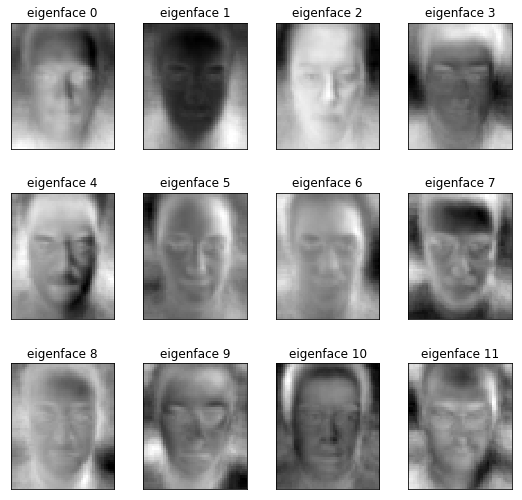

In [34]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
print(eigenfaces.shape)
plot_gallery(eigenfaces, eigenface_titles, IMG_SHAPE[0], IMG_SHAPE[1])

Explained variance :

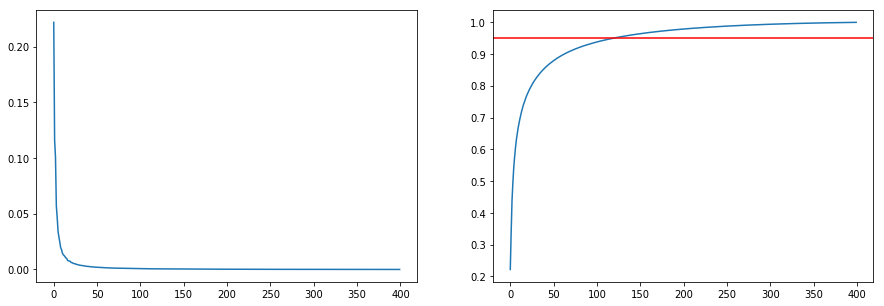

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95,color='red')

Mean face :

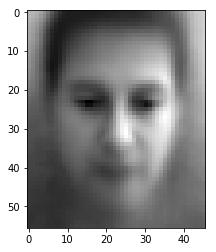

In [36]:
plt.imshow(pca.mean_.reshape((h, w)).T, cmap=plt.cm.gray)

# Reconstruction

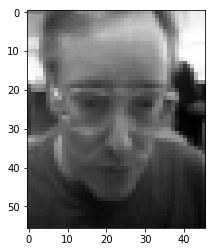

In [91]:
# Random picking up a face in the testing set
face_to_test_idx = np.random.choice(range(X_test.shape[0]))
plt.imshow(X_test[face_to_test_idx].reshape((h, w)).T, cmap=plt.cm.gray)

In [16]:
def project(image, mean, base):
    # Projecting this face on the PCA bases
    norm_image = image - mean
    components=np.zeros(len(base))
    for i in range(len(base)):
        components[i] = np.dot(norm_image, base[i])
    return components

In [17]:
def reconstruct(components, mean, base):
    reconstructed_image = np.zeros(h*w)
    reconstructed_image += mean
    for i in range(len(components)):
        reconstructed_image += components[i] * base[i]
    return reconstructed_image

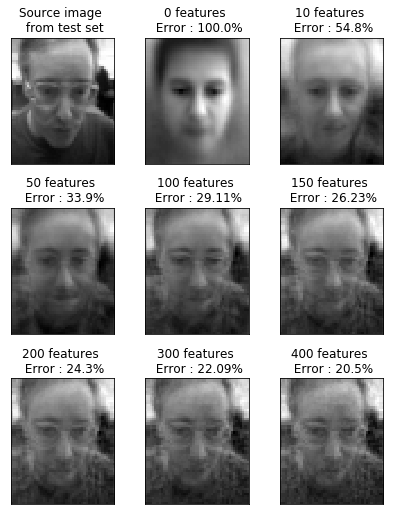

In [94]:
test_dim = [0,10,50,100,150,200,300,400]
components = project(X_test[face_to_test_idx], pca.mean_, pca.components_)
images = np.empty((len(test_dim)+1, h, w))
titles = []
images[0] = X_test[face_to_test_idx].reshape((h, w))
true_norm = np.linalg.norm(X_test[face_to_test_idx] - pca.mean_)
titles.append("Source image \n from test set")
for i, dim in enumerate(test_dim):
    raw_image = reconstruct(components[:dim], pca.mean_, pca.components_)
    images[i+1] = raw_image.reshape((h, w))
    diff = raw_image - X_test[face_to_test_idx]
    titles.append(str(dim) + " features \n Error : " + str(round(np.linalg.norm(diff)/true_norm*100, 2)) + "%")
plot_gallery(images, titles, h, w, n_row=3, n_col=3)

# Recognition using kNN

In [8]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', KNeighborsClassifier())
])

N_FEATURES_OPTIONS = [10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200, 300]
N_NEIGHBOORS = [1,2,3]
param_grid = [
    {
        'reduce_dim': [PCA(whiten=True)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_neighbors': N_NEIGHBOORS
    }
]
grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)], 'reduce_dim__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200, 300], 'classify__n_neighbors': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

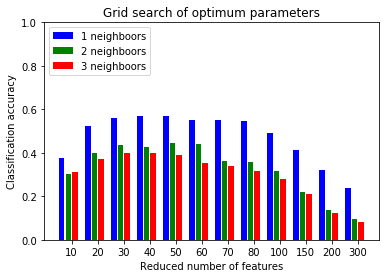

In [9]:
reducer_labels = [str(i) + ' neighboors' for i in N_NEIGHBOORS]

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(N_NEIGHBOORS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=1)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Grid search of optimum parameters")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()

In [10]:
print(grid.best_params_)

{'classify__n_neighbors': 1, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True), 'reduce_dim__n_components': 40}


Best score :  0.6057692307692307


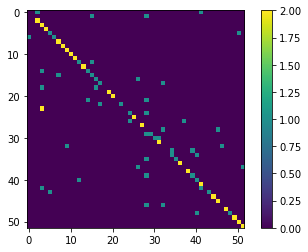

In [11]:
y_pred = grid.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, interpolation='nearest')
plt.colorbar()
accuracy = np.count_nonzero(y_pred == y_test) / len (y_test)
print("Best score : ", accuracy)

Image 12 class 3  predicted  3
Image 12 class 3


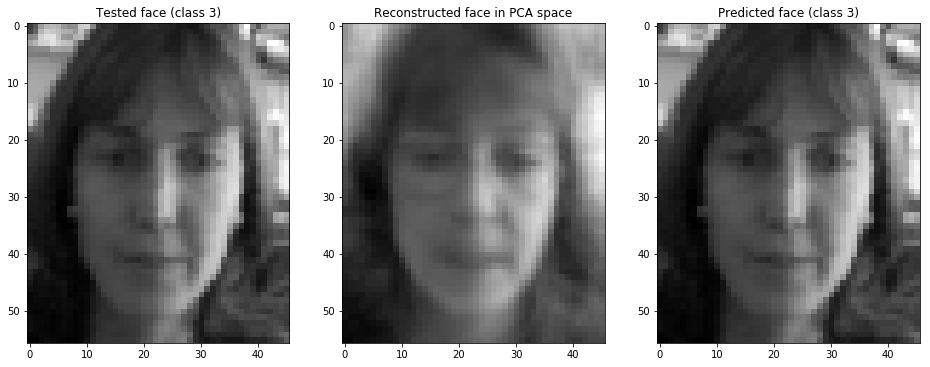

In [28]:
feature_to_test = 3
# Search classification errors
(i,c) = next((idx,feature) for (idx,feature) in enumerate(y_test) if feature == feature_to_test)
print("Image", i, "class", c, " predicted ", y_pred[i])
# Search image of the wrong class
(i_2,c_2) = next((idx,feature) for (idx,feature) in enumerate(y_test) if feature == y_pred[i])
print("Image", i_2, "class", c_2)

pca = grid.best_estimator_.named_steps['reduce_dim']
components = project(X_test[i], pca.mean_, pca.components_)
reconstructed_image = reconstruct(components[:40], pca.mean_, pca.components_)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Tested face (class 3)")
plt.imshow(X_test[i].reshape((h, w)).T, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Reconstructed face in PCA space")
plt.imshow(reconstructed_image.reshape((h, w)).T, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Predicted face (class 3)")
plt.imshow(X_test[i_2].reshape((h, w)).T, cmap=plt.cm.gray)

# Recognition using alternative method


In [29]:
 def gen_pca_per_classes(n, X_tr, y_tr):
    # Sorting of eigenfaces per classes
    indexes_per_classes = dict()
    for f in set(y_train):
        indexes_per_classes[f] = [i for i, c in enumerate(y_tr) if c == f]
    # Construction of subspaces per classes
    pca_per_classes = dict()
    for f, idx in indexes_per_classes.items():
        pca_per_classes[f] = PCA(n_components=n, whiten=True).fit(X_tr[idx,:])
    return pca_per_classes

In [30]:
# Error estimation using projection/recosntruction and prediction
def predict_using_class_subspaces(X, y, pcas):
    y_pred = np.empty(len(y))
    for i, image_to_test in enumerate(X):
        error_per_classes = dict()
        for f, pca in pcas.items():
            coefs = project(image_to_test, pca.mean_, pca.components_)
            reconstructed_image = reconstruct(coefs, pca.mean_, pca.components_)
            error_per_classes[f] = np.linalg.norm(image_to_test - reconstructed_image)
        y_pred[i] = min(error_per_classes, key=error_per_classes.get)
        accuracy = np.count_nonzero(y_pred == y) / len (y)
    return y_pred, accuracy

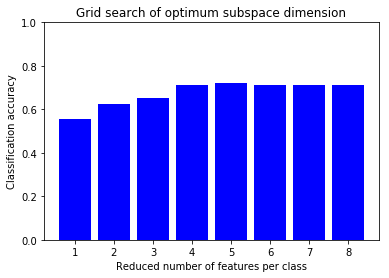

In [31]:
PCA_COMPONENTS = [1,2,3,4,5,6,7,8]

plt.figure()
for n in PCA_COMPONENTS:
    pca_per_classes = gen_pca_per_classes(n, X_train, y_train)
    y_pred, accuracy = predict_using_class_subspaces(X_test, y_test, pca_per_classes)
    plt.bar(n, accuracy, label=n, color='b')
    
plt.title("Grid search of optimum subspace dimension")
plt.xlabel('Reduced number of features per class')
plt.ylabel('Classification accuracy')
plt.ylim((0, 1))

plt.show()

Best accuracy : 0.7115384615384616


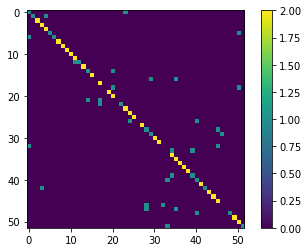

In [32]:
pca_per_classes = gen_pca_per_classes(6, X_train, y_train) # 6 give the best accuracy
y_pred, accuracy = predict_using_class_subspaces(X_test, y_test, pca_per_classes)
conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, interpolation='nearest')
plt.colorbar()
accuracy = np.count_nonzero(y_pred == y_test) / len (y_test)
print("Best accuracy :", accuracy)

Image 63 class 22  predicted  18.0
Image 9 class 18


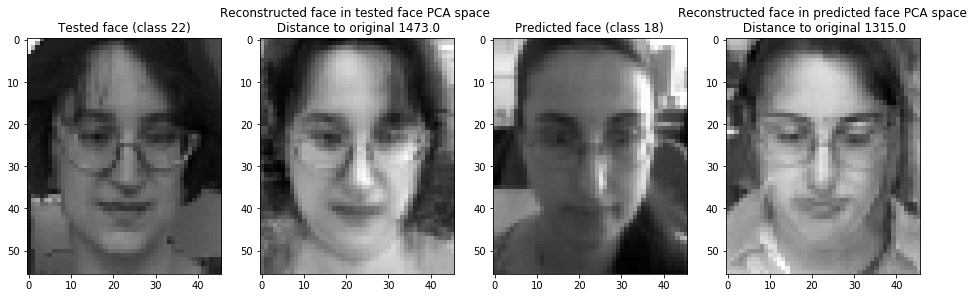

In [43]:
feature_to_test = 22
# Search classification errors
(i,c) = next((idx,feature) for (idx,feature) in enumerate(y_test) if feature == feature_to_test)
print("Image", i, "class", c, " predicted ", y_pred[i])
# Search image of the wrong class
(i_2,c_2) = next((idx,feature) for (idx,feature) in enumerate(y_test) if feature == y_pred[i])
print("Image", i_2, "class", c_2)

pca = pca_per_classes[feature_to_test]
components = project(X_test[i], pca.mean_, pca.components_)
reconstructed_image = reconstruct(components[:6], pca.mean_, pca.components_)
reconstruct_error = round(np.linalg.norm(X_test[i] - reconstructed_image))
pca = pca_per_classes[c_2]
components = project(X_test[i], pca.mean_, pca.components_)
reconstructed_image2 = reconstruct(components[:6], pca.mean_, pca.components_)
reconstruct_error2 = round(np.linalg.norm(X_test[i] - reconstructed_image2))

plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.title("Tested face (class 22)")
plt.imshow(X_test[i].reshape((h, w)).T, cmap=plt.cm.gray)
plt.subplot(1,4,2)
plt.title("Reconstructed face in tested face PCA space \n Distance to original " + str(reconstruct_error))
plt.imshow(reconstructed_image.reshape((h, w)).T, cmap=plt.cm.gray)
plt.subplot(1,4,3)
plt.title("Predicted face (class 18)")
plt.imshow(X_test[i_2].reshape((h, w)).T, cmap=plt.cm.gray)
plt.subplot(1,4,4)
plt.title("Reconstructed face in predicted face PCA space\n Distance to original " + str(reconstruct_error2))
plt.imshow(reconstructed_image2.reshape((h, w)).T, cmap=plt.cm.gray)

# PCA-LDA + NN

In [44]:
pipe = Pipeline([
    ('reduce_dim_PCA', PCA()),
    ('reduce_dim_LDA', LinearDiscriminantAnalysis()),
    ('classify', KNeighborsClassifier())
])

N_FEATURES_OPTIONS_PCA = [10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200, 300]
N_FEATURES_OPTIONS_LDA = [10, 15, 20, 25, 30, 35, 40, 45, 50]
N_NEIGHBOORS = [1]
param_grid = [
    {
        'reduce_dim_PCA': [PCA(whiten=True)],
        'reduce_dim_PCA__n_components': N_FEATURES_OPTIONS_PCA,
        'reduce_dim_LDA': [LinearDiscriminantAnalysis(store_covariance=True)],
        'reduce_dim_LDA__n_components': N_FEATURES_OPTIONS_LDA,
        'classify__n_neighbors': N_NEIGHBOORS
    }
]
grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('reduce_dim_LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver=...i',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'reduce_dim_PCA': [PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)], 'reduce_dim_PCA__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200, 300], 'reduce_dim_LDA': [LinearDiscriminantAnalysis(n_components=30, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001)], 'reduce_dim_LDA__n_components': [10, 15, 20, 25, 30, 35, 40, 45, 50], 'classify__n_neigh

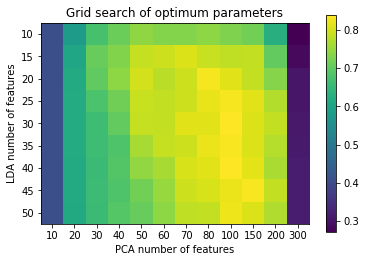

In [45]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(len(N_FEATURES_OPTIONS_LDA), len(N_FEATURES_OPTIONS_PCA))
plt.imshow(mean_scores, interpolation='nearest')
plt.title("Grid search of optimum parameters")
plt.xlabel('PCA number of features')
plt.ylabel('LDA number of features')
plt.xticks(range(len(N_FEATURES_OPTIONS_PCA)), N_FEATURES_OPTIONS_PCA)
plt.yticks(range(len(N_FEATURES_OPTIONS_LDA)), N_FEATURES_OPTIONS_LDA)
plt.colorbar()

In [46]:
print(grid.best_params_)

{'classify__n_neighbors': 1, 'reduce_dim_LDA': LinearDiscriminantAnalysis(n_components=30, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001), 'reduce_dim_LDA__n_components': 30, 'reduce_dim_PCA': PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True), 'reduce_dim_PCA__n_components': 100}


Best score :  0.875


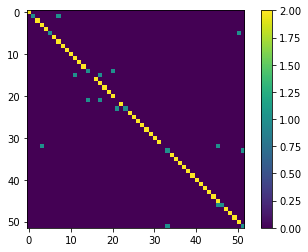

In [47]:
y_pred = grid.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, interpolation='nearest')
plt.colorbar()
accuracy = np.count_nonzero(y_pred == y_test) / len (y_test)
print("Best score : ", accuracy)

Image 80 class 33  predicted  46
Image 50 class 46


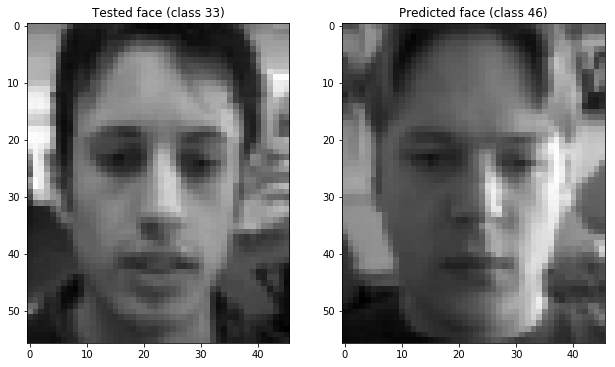

In [56]:
feature_to_test = 33
# Search classification errors
(i,c) = next((idx,feature) for (idx,feature) in enumerate(y_test) if feature == feature_to_test)
print("Image", i, "class", c, " predicted ", y_pred[i])
# Search image of the wrong class
(i_2,c_2) = next((idx,feature) for (idx,feature) in enumerate(y_test) if feature == y_pred[i])
print("Image", i_2, "class", c_2)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Tested face (class 33)")
plt.imshow(X_test[i].reshape((h, w)).T, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Predicted face (class 46)")
plt.imshow(X_test[i_2].reshape((h, w)).T, cmap=plt.cm.gray)